In [1]:
#setup 
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)
    
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

# Voting classifiers

In [2]:
#동전 던지기 (동전의 앞면이 나올확률) 
heads_proba = 0.51
#10000번을 던진다고 가정 
coin_tosses = (np.random.rand(10000, 10)<heads_proba).astype(np.int32)
#head 가 나올확률 누적 
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0)/np.arange(1, 10001).reshape(-1, 1)

Saving figure law_of_large_numbers_plot


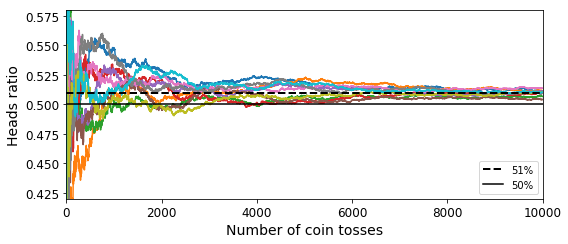

In [3]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

* moons 데이터로 logisticRegression, RandomForestClassifier, SVM 돌리기 

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

# 모델 fitting 시키기 
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...f',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         n_jobs=1, voting='hard', weights=None)

In [7]:
# 측정하기 
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


SVC 같은 경우 probability 사용을 설정해야 크로스벨리데이션을 사용하여 측정을 할수가 있고 predict_proba() 가 추가된다.

In [8]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         n_jobs=1, voting='soft', weights=None)

In [9]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


# Bagging ensembles

다양한 분류 기준을 얻는 방법으로 각 다른 알고리즘에 명시적으로 train data 를 나눠 돌리는 방식으로 나눌 수도 있고 같은 알고리즘에 다른 random subsets 를 돌릴 수도 있다.  

* Sampling 방식에 따라 
    * bagging : 각각 다른 random subset 을 돌림 (short for bootstrap aggregation)
    * pasting : 각각 같은 random subset 을 돌림 
    
* aggregation function 
    * statistical mode
    * average 

In [10]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# 100 개의 샘플을 가지고 돌림 
# n_estimators=500 500개의 의사 결정 분류기 사용
# bootstrap=True : bagging
# n_jobs=-1 : 사용 가능한 CPU 코어 모두 사용 
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=100, n_estimators=500, n_jobs=-1, oob_score=False,
         random_state=42, verbose=0, warm_start=False)

In [11]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.912


In [16]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


* single Decision VS Decision Tree (500) with bagging 

In [17]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap, linewidth=10)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Saving figure decision_tree_without_and_with_bagging_plot


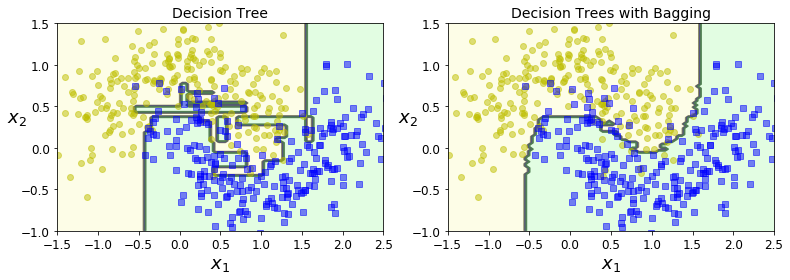

In [18]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

* BaggingClassifier 는 기본적으로 soft voting 을 사용 (Decision Tress의 경우 predict_proda() 를 가지고 있음)

## Out-of-Bag Evaluation

random sample 을 진행하는 경우 sampling 된 데이타 중 계쏙 되는 선택되는것과 안되는 것이 있다. 이때 계속 선택되지 못하는 경우 OOB 라고 한다. 

OOB 는 train 할때 분류기가 전혀 보지 못한 데이터여서 validation 에 사용 할수 있다. 
(즉, 다른 test 데이터를 분류 할 필요가 없어진다.) 

In [20]:
# OOB 를 사용하여 검증한 경우 
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.90133333333333332

In [21]:
# 실제 테스트 데이터를 사용하여 검증한 경우 
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.91200000000000003

In [24]:
bag_clf.oob_decision_function_[:10]

array([[ 0.31746032,  0.68253968],
       [ 0.34117647,  0.65882353],
       [ 1.        ,  0.        ],
       [ 0.        ,  1.        ],
       [ 0.        ,  1.        ],
       [ 0.08379888,  0.91620112],
       [ 0.31693989,  0.68306011],
       [ 0.02923977,  0.97076023],
       [ 0.97687861,  0.02312139],
       [ 0.97765363,  0.02234637]])

# Random Patches and Random Subspaces

BaggingClassifier 는 features sampling 이 가능하다. (max_features 와 bootstrap_features 파라메터를 이용)

* Random Patches : 높은 차원에 이미지를 이용할 때 사용, traning instances 와 features 모두 sampling (bootstrap=False and max_samples=1.0)
* Random Subspaces : sampleing features (bootstrap_features=True and/or max_features smaller than 1.0) 


# Random Forests

* ensemble of Decision Trees, 주로 bagging method (or sometimes pasting) 을 이용하고, max_samples 은 training set 에 맞춘다. 

BaggingClassifier and DecisionTreeClassifier 를 다 사용하기 보다는 RandomForestClassifier 를 사용하면 옵션을 지정할때 편하다. 

   

In [28]:
# BaggingClassifier and DecisionTreeClassifier 를 이용하여 모델 만들기 
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)

In [32]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [33]:
# RandomForestClassifier 이용
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [34]:
# 두 결과 비교 
np.sum(y_pred == y_pred_rf) / len(y_pred) 

0.97599999999999998

거의 동일한 예측을 함 

## Extra-Trees

가능한 최상의 임계 값을 찾는 대신 각 기능에 대해 임의의 임계 값을 사용하여 나무를 훨씬 더 무작위로 만들 수 있다.

Extremely Randomized Trees ensemble

ExtraTreesClassifier 를 사용한다. (RandomForestRegressor 와 같은 API 를 사용함) 

무엇을 사용할지는 주로 두 classifier 를 돌려서 cross-validation (and tuning
the hyperparameters using grid search) 한다. 

## Feature Importance

중요한 feature 가 root 에 나타나기도 하지만 그렇지 않은 경우도 있다. 

forest 의 모든 트리에 나타나는 평균 depth 를 측정하여 feature importance 를 측정 할 수 있다. 


In [35]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [36]:
rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [37]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.hot,
               interpolation="nearest")
    plt.axis("off")

Saving figure mnist_feature_importance_plot


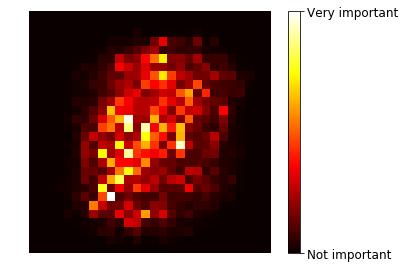

In [38]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

변수를 선택할때 사용한다.

# Boosting

originally called hypothesis boosting

weak learners into a strong learner 를 여러개 combine 하여 앙상블을 만드는 방법이다. 

순차적으로 predictor 를 predecessor (이전 predictor) 에 맞게 트레이닝 시키는 방법이다. 

## AdaBoost

short for Adaptive Boosting

잘못 분류된 부분을 상대적 가중치를 부여하여 다음 predictor 에 넘겨주는 방식이다. 

* sequential learning tech 는 병렬화가 불가능한 것이 단점이다. (부분적으로만 가능) 

* SAMME (Stagewise Additive Modeling using a Multiclass Exponential loss function)
Scikit-Learn 에서는 AdaBoost의 다중 클래스 버전으로 SAMME 사용한다. 클래스가 두 개인 경우 SAMME는 AdaBoost와 동일하다. 더욱이, predictor가 클래스 확률을 예측할 수 있다면 (예 : predict_proba () 메소드가있는 경우), Scikit-Learn은 SAMME.R (R은 "Real"을 나타냄)이라는 SAMME 변형을 사용하여 클래스 확률 예측보다 더 잘 수행된다.

In [39]:
from sklearn.ensemble import AdaBoostClassifier

# 2개의 leaf node 만 있는 DecisionTress 200 개 생성 
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

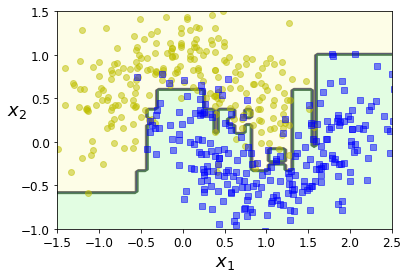

In [40]:
plot_decision_boundary(ada_clf, X, y)

overfitting 되는 경우 estimators 를 줄이거나 strongly regularizing the base estimator 한다. 

In [41]:
# 사용 할 수 있는 변수들 
list(m for m in dir(ada_clf) if not m.startswith("_") and m.endswith("_"))

['base_estimator_',
 'classes_',
 'estimator_errors_',
 'estimator_weights_',
 'estimators_',
 'feature_importances_',
 'n_classes_']

# Gradient Boosting

adaboost 와 비슷하게 sequentially adding predictors 한다. 

이 방법은 새로운 예측 인자를 이전의 예측 인자에 의해 생성 된 residual errors에 맞추려고 시도한다. 

In [42]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

### 의사 결정 트리를 기본 예측 자로 사용하는 간단한 회귀 예제

DecisionTreeRegressor 를 fitting 시키고 on the residual errors made by the first predictor 로 second DecisionTreeRegressor 를 학습 시킨다. 

In [43]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=42,
           splitter='best')

In [44]:
#residual error 
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=42,
           splitter='best')

In [45]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=42,
           splitter='best')

In [46]:
# 값 예측 
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([ 0.75026781])

나무가 앙상블에 추가됨에 따라 앙상블의 예측이 점점 좋아진다. 

* Scikit-Learn’s GradientBoostingRegressor 사용
RandomForestRegressor class와 같이 hyperparameters를 가진다. control the growth of Decision Trees (e.g., max_depth, min_samples_leaf, and so on), control the ensemble training, such as the number of trees (n_estimators)

In [48]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1.0, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=3, presort='auto',
             random_state=42, subsample=1.0, verbose=0, warm_start=False)

In [49]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=200,
             presort='auto', random_state=42, subsample=1.0, verbose=0,
             warm_start=False)

In [51]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)


Saving figure gbrt_learning_rate_plot


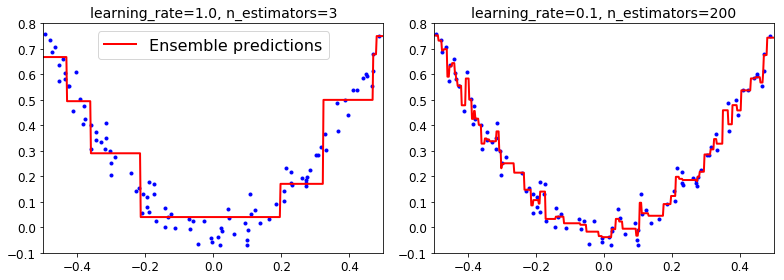

In [52]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

save_fig("gbrt_learning_rate_plot")
plt.show()

Saving figure gradient_boosting_plot


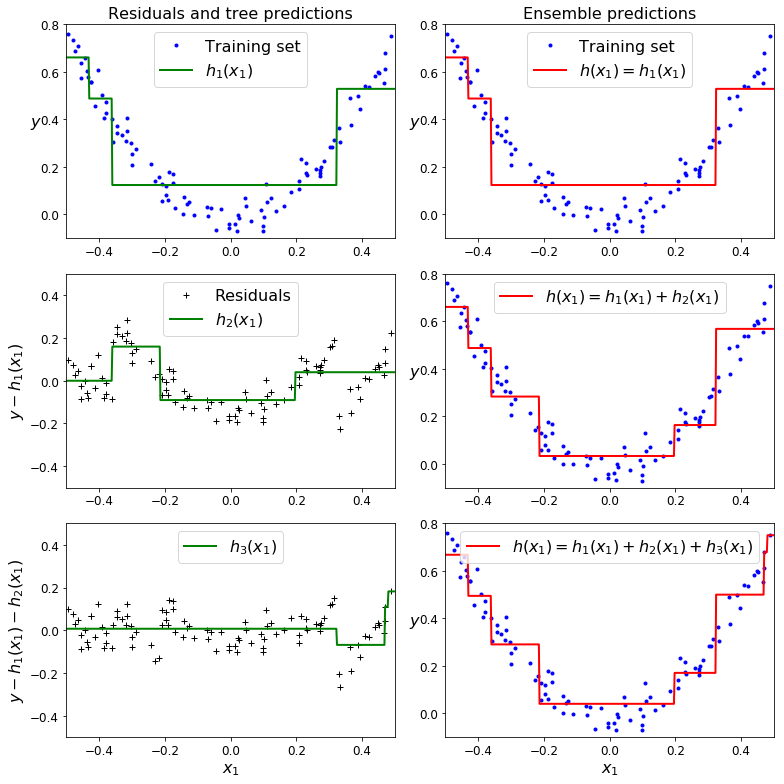

In [53]:
# 잔차와 트리 예측 
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

learning_rate 를 0.1 보다 더 낮게 설정하면 더 많은 나무가 필요하지만 예측은 더 잘된다. 이것이 shrinkage 라고 하는  regularization technique  기법이다. 

## Gradient Boosting with Early stopping

tree 의 가장 적절한 개수를 찾기 위한 방법

staged_predict() 구현되어 있다. 

In [54]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

# 각각의 에러들을 수집 
errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
# 최저값을 저장 
bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=55, presort='auto',
             random_state=42, subsample=1.0, verbose=0, warm_start=False)

In [55]:
min_error = np.min(errors)

Saving figure early_stopping_gbrt_plot


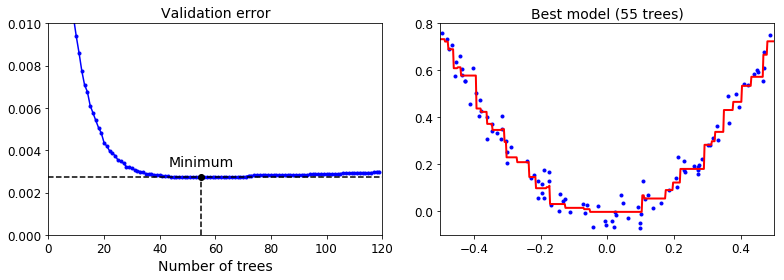

In [56]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

save_fig("early_stopping_gbrt_plot")
plt.show()

* 또한 실제로 많은 수의 나무를 훈련시킨 다음 최적의 수를 찾기 위해 일찍 훈련을 중지함으로써 조기 정지를 구현할 수 있다.

warm_start=True 옵션을 사용

In [57]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    
    #유효성 검사 오류가 연속 5 회 반복되어 개선되지 않으면 교육을 중지
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

* 또한 GradientBoostingRegressor는 subsample 을 사용 하여 각 트리를 학습하는 데 사용할 학습 인스턴스의 비율을 지정할 수 있다. 

subsample=0.25 tree is trained on 25% of the training instances, selected randomly (Stochastic Gradient Boosting)


# Stacking

short for stacked generalization

* 새로운 인스턴스에서 회귀 작업을 수행하는 앙상블

* 하위 3 개의 예측 변수 각각은 다른 값 (3.1, 2.7 및 2.9)을 예측 한 다음 최종 예측 변수 (blender, or a meta learner)는 이러한 예측을 입력으로 사용하여 최종 예측을 만든다 (3.0).

Figure 7-12. Aggregating predictions using a blending predictor (참고)

* Blender 학습 
    먼저 training set 을 2개로 나누고 첫번째 subset 은 predictor 를 학습하는데 사용한다. 다음, 첫번째 predictor 는 다음 second set 을 이용해 예측한다.  
    
    이제 모든 세트의 각 인스턴스에 대해 세 가지 예측 된 값을 입력 피쳐로 사용하여 새 교육 세트를 만들 수 있다 (이 새 교육 세트를 3 차원으로 설정 함). (목표값은 유지한다)
    
    blender는 이 새로운 교육 세트에 대해 교육을 받았으므로 첫 번째 레이어의 예상치에 따라 목표 값을 예측하는 방법을 배우게된다. 

Alternatively, you can use an open source implementation such as brew (available at https://github.com/viisar/brew).

참고 ) 
https://swalloow.github.io/bagging-boosting

Bagging이 일반적인 모델을 만드는데 집중되어있다면, Boosting은 맞추기 어려운 문제를 맞추는데 초점이 맞춰져 있다.

Stacking : Two heads are better than one  서로 다른 모델들을 조합해서 최고의 성능을 내는 모델을 생성